In [29]:
from pathlib import Path
import numpy as np
import torch
import hydra
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import nibabel as nib


from fetalsyngen.data.datasets import FetalSynthDataset

from fetalsyngen.generator.model import FetalSynthGen
from fetalsyngen.generator.augmentation.synthseg import RandBiasField, RandGamma, RandNoise, RandResample
from fetalsyngen.generator.deformation.affine_nonrigid import  SpatialDeformation
from fetalsyngen.generator.intensity.rand_gmm import  ImageFromSeeds
from fetalsyngen.generator.artifacts.simulate_reco import Scanner
from fetalsyngen.generator.augmentation.artifacts import  StackSampler
from fetalsyngen.generator.artifacts.utils import ScannerParams
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Generation time: 0.4212183952331543
Image shape: torch.Size([1, 1, 96, 96, 50]), type: torch.float32, range: [0.0, 1.0], device: cpu
Label shape: torch.Size([1, 1, 96, 96, 50]), type: torch.int64, range: [0, 7], device: cpu


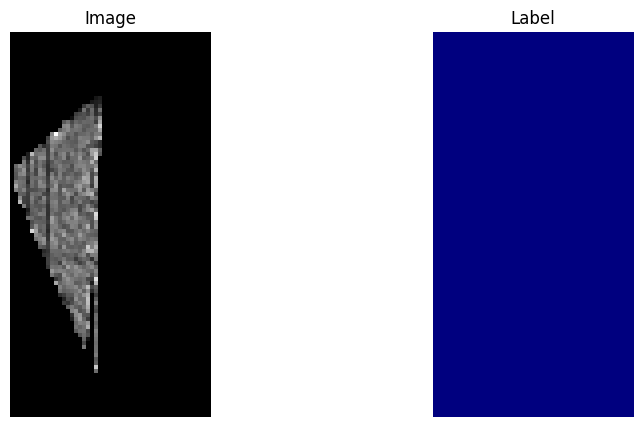

In [ ]:
def plot_imgs(data, slice=128):
    # print("Data keys:", data.keys())
    # if 'name' in data:
    #     print("Name:", data['name'])
    print("Generation time:", data["generation_params"]["generation_time"])
    # print shape, type, range, device
    print(
        f"Image shape: {data['image'].shape}, type: {data['image'].dtype}, range: [{data['image'].min()}, {data['image'].max()}], device: {data['image'].device}"
    )
    print(
        f"Label shape: {data['label'].shape}, type: {data['label'].dtype}, range: [{data['label'].min()}, {data['label'].max()}], device: {data['label'].device}"
    )

    # if cuda tensor, move to cpu
    if data["image"].is_cuda:
        data["image"] = data["image"].cpu()
    if data["label"].is_cuda:
        data["label"] = data["label"].cpu()

    # remove channel dimension
    data["image"] = data["image"].squeeze()
    data["label"] = data["label"].squeeze()

    # plot image label
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data["image"][:, slice, :], cmap="gray")
    axes[0].set_title("Image")
    axes[0].axis("off")
    axes[1].imshow(data["label"][:, slice, :], cmap="jet")
    axes[1].set_title("Label")
    axes[1].axis("off")
    plt.show()


def squeeze_rotate(img):
    img = img.squeeze().cpu().numpy()
    img = img.transpose(1, 2, 0)
    img = img[::-1, :, :]
    return img


def plot_sidebyside(s1, s2, test_name):
    print(f'Simple image generation time: {s1["generation_params"]["generation_time"]}')
    print(
        f'{test_name} image generation time: {s2["generation_params"]["generation_time"]}'
    )
    img1, img2 = s1["image"], s2["image"]
    lab1, lab2 = s1["label"], s2["label"]

    img1 = squeeze_rotate(img1)
    img2 = squeeze_rotate(img2)
    lab1 = squeeze_rotate(lab1)
    lab2 = squeeze_rotate(lab2)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].imshow(img1[:, 128, :], cmap="gray")
    axs[0, 0].set_title("Simple image")
    axs[0, 0].axis("off")
    axs[0, 1].imshow(img2[:, 128, :], cmap="gray")
    axs[0, 1].set_title(f"{test_name} Test image")
    axs[0, 1].axis("off")
    axs[1, 0].imshow(lab1[:, 128, :], cmap="jet")
    axs[1, 0].set_title("Simple label")
    axs[1, 0].axis("off")
    axs[1, 1].imshow(lab2[:, 128, :], cmap="jet")
    axs[1, 1].set_title(f"{test_name} Test label")
    axs[1, 1].axis("off")
    plt.tight_layout()
    plt.show()


intensity_generator = ImageFromSeeds(
    min_subclusters=1,
    max_subclusters=6,
    seed_labels=[
        0,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        29,
        30,
        31,
        32,
        33,
        34,
        35,
        36,
        37,
        38,
        39,
        40,
        41,
        42,
        43,
        44,
        45,
        46,
        47,
        48,
        49,
    ],
    generation_classes=[
        0,
        10,
        10,
        10,
        10,
        10,
        10,
        10,
        10,
        10,
        10,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        30,
        30,
        30,
        30,
        30,
        30,
        30,
        30,
        30,
        30,
        40,
        41,
        42,
        43,
        44,
        45,
        46,
        47,
        48,
        49,
    ],
    meta_labels=4,
)
spatial_deform = SpatialDeformation(
    max_rotation=20,
    max_shear=0.02,
    max_scaling=0.1,
    size=(256, 256, 256),
    prob=1,
    nonlinear_transform=True,
    nonlin_scale_min=0.03,
    nonlin_scale_max=0.06,
    nonlin_std_max=4,
    flip_prb=0.5,
    device="cuda:0",
)
resampler = RandResample(prob=0.5, max_resolution=1.5, min_resolution=0.5)
bias_field = RandBiasField(
    prob=0.5, scale_min=0.004, scale_max=0.02, std_min=0.01, std_max=0.3
)
noise = RandNoise(prob=0.5, std_min=5, std_max=15)
gamma = RandGamma(prob=0.5, gamma_std=0.1)

simple_synth_gen = generator = FetalSynthGen(
    shape=(256, 256, 256),
    resolution=(0.5, 0.5, 0.5),
    device="cuda:0",
    intensity_generator=intensity_generator,
    spatial_deform=spatial_deform,
    resampler=resampler,
    bias_field=bias_field,
    noise=noise,
    gamma=gamma,
)

simple_synth_ds = FetalSynthDataset(
    bids_path="./../data",
    generator=simple_synth_gen,
    seed_path="./../data/derivatives/seeds",
    sub_list=None,
)


# Instantiate ScannerParams
scanner_params = ScannerParams(
    resolution_slice_fac_min=0.5,
    resolution_slice_fac_max=3.5,
    resolution_slice_max=3.5,
    slice_thickness_min=1,
    slice_thickness_max=5,
    gap_min=0,
    gap_max=1,
    min_num_stack=1,
    max_num_stack=1,
    max_num_slices=None,
    noise_sigma_min=0,
    noise_sigma_max=0.01,
    TR_min=1,
    TR_max=2,
    prob_gamma=0.1,
    gamma_std=0.05,
    prob_void=0.2,
    slice_size=None,
    restrict_transform=False,
    txy=3.0,
)

stack_sampler = StackSampler(
    scanner_params=scanner_params,
    prob=1,
    resolution_recon=1,
    device="cuda:0",
)

# SR ARTIFACTS CLASSES

# Instantiate BlurCortex
test_name = "SimulateMotion"
# Instantiate SimulatedBoundaries

test_gen = FetalSynthGen(
    shape=(256, 256, 256),
    resolution=(0.5, 0.5, 0.5),
    device="cuda:0",
    intensity_generator=intensity_generator,
    spatial_deform=spatial_deform,
    resampler=resampler,
    bias_field=bias_field,
    noise=noise,
    gamma=gamma,
    stack_sampler=stack_sampler,
)

test_dataset = FetalSynthDataset(
    bids_path="./../data",
    generator=test_gen,
    seed_path=None,  # "./../data/derivatives/seeds",
    load_image=True,
    image_as_intensity=True,
    sub_list=None,
)

simple_real_ds = FetalSynthDataset(
    bids_path="./../data",
    generator=simple_synth_gen,
    seed_path=None,  # This makes the intensity generator to use the real image
    sub_list=None,
    load_image=True,  # This makes the intensity generator to use the real image
    image_as_intensity=True,  # This makes the intensity generator to use the real image
    
)

# save images
data = test_dataset.sample_with_meta(0)
img = data["image"].squeeze().cpu().numpy()
img = img.transpose(1, 2, 0)
img = img[::-1, :, :]
img = nib.Nifti1Image(img, np.eye(4))
nib.save(img, "test_img.nii.gz")

seg = data["label"].squeeze().cpu().numpy()
seg = seg.transpose(1, 2, 0)
seg = seg[::-1, :, :].astype(np.int8)
seg = nib.Nifti1Image(seg, np.eye(4))
nib.save(seg, "test_seg.nii.gz")

for i in range(1):
    for j in range(1):
        plot_imgs(data, slice=90)